<a href="https://colab.research.google.com/github/GenieYoung/Moving-mesh-based-on-harmonic-maps/blob/main/moving_mesh_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

try:
  import matplotlib.pyplot as plt
except:
  warning("Matplotlib not imported")

import numpy as np

# Utility Function

In [2]:
def copy_mesh(mesh):
  coord_space = mesh.coordinates.function_space()
  new_coords = firedrake.Function(coord_space).assign(mesh.coordinates)
  return firedrake.Mesh(new_coords)

def draw_mesh(mesh, label=""):
  fig,ax = plt.subplots()
  firedrake.pyplot.triplot(mesh, axes=ax)
  ax.set_title(label)
  ax.legend()
  plt.show()

def draw_function(F, label=""):
  fig, ax = plt.subplots()
  colors = firedrake.pyplot.tripcolor(F, axes=ax)
  fig.colorbar(colors)
  ax.set_title(label)
  plt.show()

# Build initial physical mesh

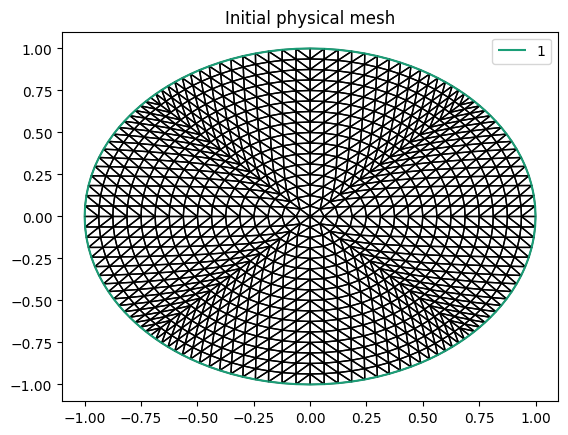

In [3]:
x_mesh = firedrake.UnitDiskMesh(4)
#x_mesh.coordinates.dat.data[:] = x_mesh.coordinates.dat.data/2 + [0.5,0.5]

draw_mesh(x_mesh, "Initial physical mesh")

# Build initial logical mesh by solving following Laplace equation
$$
Δξ = 0,\, x \in \Omega\\
\xi |_{\partial\Omega} = \xi_b
$$

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


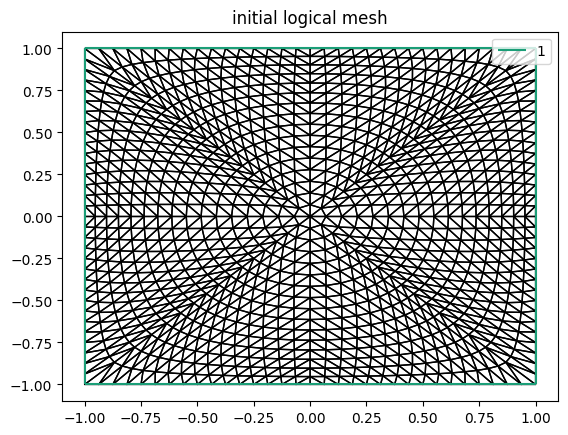

In [4]:
def square_boundary(x,y):
  m = firedrake.ufl.max_value(abs(x), abs(y))
  if m == 0:
    return [0,0]
  else:
    return [x/m,y/m]

def solve_Laplace_equation(mesh):
  VFS = firedrake.VectorFunctionSpace(mesh, "Lagrange", 1)
  xi = firedrake.TrialFunction(VFS)
  vt = firedrake.TestFunction(VFS)

  F = firedrake.ufl.inner(firedrake.ufl.grad(xi), firedrake.ufl.grad(vt))*firedrake.ufl.dx

  x,y = firedrake.SpatialCoordinate(mesh)
  bc_expr = firedrake.as_vector(square_boundary(x,y))
  bc_func = firedrake.Function(VFS)
  bc_func.interpolate(bc_expr)
  bc = firedrake.DirichletBC(VFS, bc_func, 1)

  xi_solution = firedrake.Function(VFS)
  problem = firedrake.LinearVariationalProblem(F,0,xi_solution,bcs=bc)
  solver = firedrake.LinearVariationalSolver(problem)
  solver.solve()

  return xi_solution

initial_xi_solution = solve_Laplace_equation(x_mesh)
initial_xi_mesh = firedrake.Mesh(initial_xi_solution)
draw_mesh(initial_xi_mesh, "initial logical mesh")

# Define benchmark function and metrics

$$
u(x,y)=\tanh(-30[\frac{y}{2}-0.25\sin(\pi x + \pi)])
$$

$$
M(x) = \sqrt{1+0.1||\nabla u||_2^2}
$$

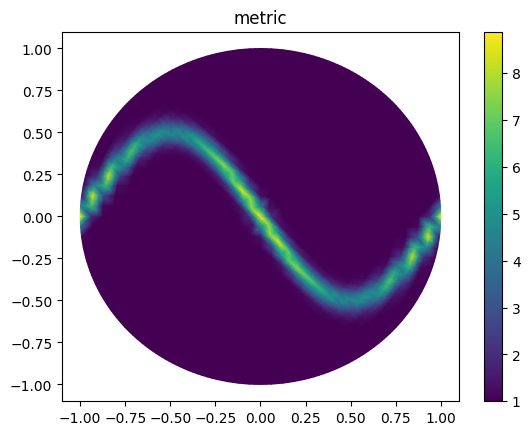

In [5]:
def U_real(mesh):
  x,y = firedrake.ufl.SpatialCoordinate(mesh)
  return firedrake.ufl.tanh(-30*(y/2-0.25*firedrake.ufl.sin(firedrake.ufl.pi*x+firedrake.ufl.pi)))

# def U_real(mesh):
#   x,y = firedrake.ufl.SpatialCoordinate(mesh)
#   return firedrake.ufl.tanh(20*(y-0.5))

# def U_real(mesh):
#   x,y = firedrake.ufl.SpatialCoordinate(mesh)
#   #p = 50*((x-0.5)**2+(y-0.5)**2-0.09)
#   p = 50*(x+y-1)**2
#   return 1+20/(firedrake.ufl.exp(p)+firedrake.ufl.exp(-p))

# def U_x(mesh):
#   x,y = firedrake.ufl.SpatialCoordinate(mesh)
#   return (15*firedrake.ufl.pi*firedrake.ufl.cos(2*firedrake.ufl.pi*x))*(1-U_real(mesh)**2)

# def U_y(mesh):
#   return -30*(1-U_real(mesh)**2)

def Metric(mesh):
  return firedrake.ufl.sqrt(1+0.1*(firedrake.ufl.Dx(U_real(mesh),0)**2+firedrake.ufl.Dx(U_real(mesh),1)**2))
  #return firedrake.ufl.sqrt(1+0.1*(U_x()**2+U_y()**2))

def MF(mesh):
  M = firedrake.function.Function(firedrake.functionspace.FunctionSpace(mesh,'Lagrange',1))
  M.interpolate(Metric(mesh))
  return M

draw_function(MF(x_mesh), "metric")

# Solve the following Possion equation

$$
\begin{cases}
-\nabla \cdot (\frac{1}{M(x)}\nabla \xi) = 0, \\
\xi|_{\partial \Omega} = \xi_b,
\end{cases}\\
$$

# The weak form equation is
$$
\int_\Omega \frac{1}{M(x)}\nabla\xi:\nabla\phi dx=0 \quad \forall \phi\in H_0^1(\Omega)^2
$$

In [6]:
def solve_possion_equation(mesh):
  VFS = firedrake.VectorFunctionSpace(mesh, "Lagrange", 1)
  xi = firedrake.TrialFunction(VFS)
  vt = firedrake.TestFunction(VFS)

  x,y = firedrake.ufl.SpatialCoordinate(mesh)
  a = (1/MF(mesh))*firedrake.ufl.inner(firedrake.ufl.grad(xi), firedrake.ufl.grad(vt))*firedrake.ufl.dx

  x,y = firedrake.SpatialCoordinate(mesh)
  bc_expr = firedrake.as_vector(square_boundary(x,y))
  bc_func = firedrake.Function(VFS)
  bc_func.interpolate(bc_expr)
  bc = firedrake.DirichletBC(VFS, bc_func, 1)

  xi_solution = firedrake.Function(VFS)
  problem = firedrake.LinearVariationalProblem(a, 0, xi_solution, bcs=bc)
  solver = firedrake.LinearVariationalSolver(problem)
  solver.solve()

  return xi_solution

xi_solution = solve_possion_equation(x_mesh)

# draw_function(xi_solution.sub(0), "xi_solution[0]")
# draw_function(xi_solution.sub(1), "xi_solution[1]")

# Generate new logical mesh

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


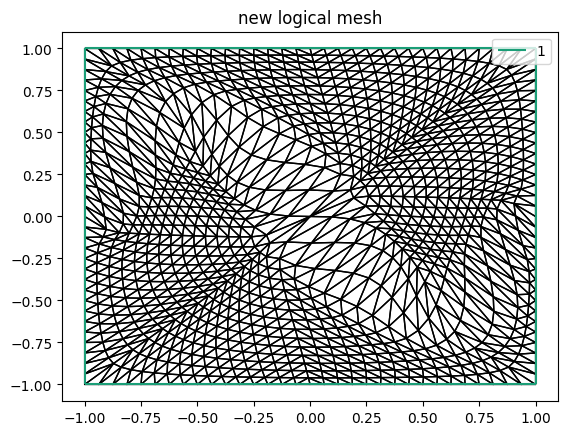

In [7]:
xi_mesh = firedrake.Mesh(xi_solution)

draw_mesh(xi_mesh, "new logical mesh")

# Generate new physical mesh

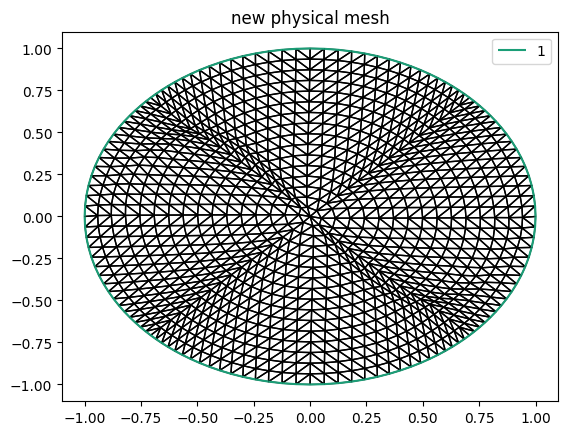

In [8]:
def generate_new_physical_mesh(x_mesh, xi_mesh, xi_solution):
  grad_space = firedrake.TensorFunctionSpace(x_mesh,"Lagrange",1)
  grad_xi = (firedrake.project(firedrake.ufl.grad(xi_solution),grad_space)).dat.data_ro
  grad_x = np.linalg.inv(grad_xi)
  grad_x = grad_x / (np.abs(np.linalg.det(grad_x)))[:,np.newaxis,np.newaxis]    # why?

  delta_xi = initial_xi_mesh.coordinates.dat.data_ro-xi_mesh.coordinates.dat.data_ro
  delta_xi_L2 = np.linalg.norm(delta_xi,axis=1).reshape(-1,1)
  delta_xi_L2[delta_xi_L2<1e-5] = 0.0
  tau = np.zeros_like(delta_xi_L2, dtype=float)
  tau[delta_xi_L2!=0] = 0.5/delta_xi_L2[delta_xi_L2!=0]
  tau = np.minimum(tau, 0.1)

  delta_x = np.einsum('ijk,ik->ij', grad_x, delta_xi)
  delta_x = delta_x*tau

  x_mesh.coordinates.dat.data[:] = x_mesh.coordinates.dat.data + delta_x

generate_new_physical_mesh(x_mesh, xi_mesh, xi_solution)

draw_mesh(x_mesh, "new physical mesh")

# Repeat above process

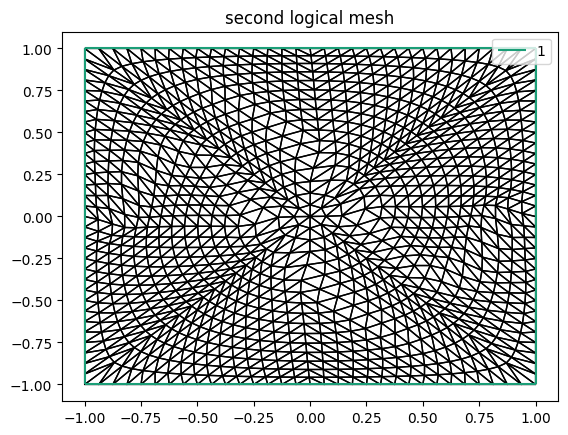

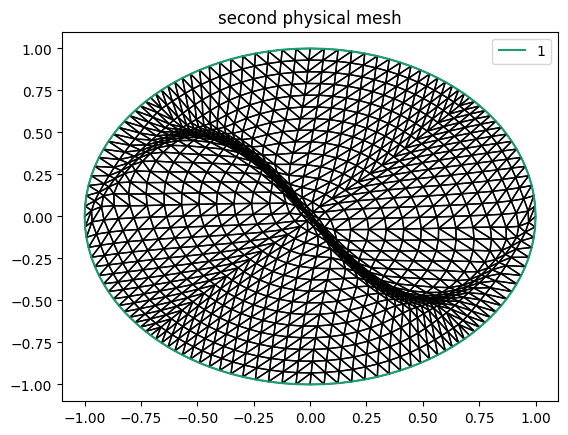

In [9]:
for i in range(10):
  xi_solution = solve_possion_equation(x_mesh)
  xi_mesh = firedrake.Mesh(xi_solution)
  generate_new_physical_mesh(x_mesh, xi_mesh, xi_solution)

draw_mesh(xi_mesh, "second logical mesh")
draw_mesh(x_mesh, "second physical mesh")